In [1]:
import glob
import json
import re
import random 
import numpy as np

def load_JSON(path_to_json, extract_subprocess = False):
    # function that gets all labels, tasks, pools and lanes
    with open(path_to_json, 'r') as f:
        data = f.read()
        json_data = json.loads(data)
        if 'childShapes' not in json_data.keys():
            print('no elements in '+path_to_json)
            return {}
        elif extract_subprocess:
            subprocess = process_subprocess(json_data['childShapes']) 
            return subprocess
        elif pool_exist(path_to_json):
            (shapes_id, follows, lanes), pools = process_pools_and_lanes(json_data['childShapes'])
            return shapes_id, follows, lanes, pools
        else:
            shapes_id, follows, flow = process_flow(json_data['childShapes'])
            return shapes_id, follows, flow

        
def pool_exist(path_to_json):
    meta_file = path_to_json.replace('.json', '.meta.json')
    with open(meta_file, 'r') as f:
        meta_data = f.read()
        json_meta_data = json.loads(meta_data)
        if 'Pool' in json_meta_data['revision']['elementCounts'].keys():
            return True
        else:
            return False  

def process_flow(shapes):
    shapes_id = {}
    follows = {}
    flow = {}
    tasks_subprocesses = ['Task', 'CollapsedSubprocess', 'Subprocess']
    shapes_unwanted = ['DataObject', 'ITSystem', 'TextAnnotation', 
                      'Association_Undirected', 'Association_Unidirectional', 'MessageFlow']
    outputs = [shapes_id, follows, flow]

    for shape in shapes:
        shape_stencil = shape['stencil']['id']
        shape_ID = shape['resourceId']
        if shape_stencil in shapes_unwanted:
            continue
        shapes_id.update({shape_ID: shape_stencil})
        
        outgoingShapes = [s['resourceId'] for s in shape['outgoing']]
        if shape_ID not in follows.keys():
            follows[shape_ID] = outgoingShapes
    
        if shape_stencil in tasks_subprocesses:
            if not shape['properties']['name'] == "":
                flow[shape_ID] = shape['properties']['name'].replace('\n', ' ').replace('\r', '').replace('  ', ' ')
            else:
                flow[shape_ID] = 'Task or Subprocess'
        else:
            if 'name' in shape['properties'] and not shape['properties']['name'] == "":
                flow[shape_ID] = shape_stencil + " (" + shape['properties']['name'].replace('\n', ' ').replace('\r', '').replace('  ', ' ') + ")"
            else:
                flow[shape_ID] = shape_stencil

    return outputs
    

def process_pools_and_lanes(shapes):
    shapes_id = {}
    follows = {}
    lanes = {}
    pools = {}
    tasks_subprocesses = ['Task', 'CollapsedSubprocess', 'Subprocess']
    shapes_unwanted = ['DataObject', 'ITSystem', 'TextAnnotation', 
                      ' Association_Undirected', 'Association_Unidirectional', 'MessageFlow']
    outputs = [shapes_id, follows, lanes]

    for shape in shapes:
        shape_stencil = shape['stencil']['id']
        shape_ID = shape['resourceId']
        if shape_stencil in shapes_unwanted:
            continue
        shapes_id.update({shape_ID: shape_stencil})
        outgoingShapes = [s['resourceId'] for s in shape['outgoing']]
        if shape_ID not in follows.keys():
            follows[shape_ID] = outgoingShapes
        
        if shape_stencil == 'Pool':
            if 'name' in shape['properties'] and not shape['properties']['name'] == "":
                pool = shape['properties']['name'].replace('\n', ' ').replace('\r', '').replace('  ', ' ')
            else:
                pool = shape_ID
            results = process_pools_and_lanes(shape['childShapes'])
            for r, o in zip(results[0], outputs):
                o.update(r)
            if len(results[0][2]): #lanes
                pools.update({pool: results[0][2]})
        
        if shape_stencil == 'Lane':
            if shape['childShapes'] != []:
                lane_labels = {}
                for childShape in shape['childShapes']:
                    c_stencil = childShape['stencil']['id']
                    c_shape_ID = childShape['resourceId']
                    if c_stencil == 'Lane':
                        if 'name' in shape['properties'] and not shape['properties']['name'] == "":
                            lane = shape['properties']['name'].replace('\n', ' ').replace('\r', '').replace('  ', ' ')
                        else:
                            lane = shape_ID
                        results = process_pools_and_lanes(shape['childShapes'])
                        for r, o in zip(results[0], outputs):
                            o.update(r)

                    else:
                        if c_stencil in shapes_unwanted:
                            continue
                        shapes_id.update({c_shape_ID: c_stencil})

                        outgoingShapes = [s['resourceId'] for s in childShape['outgoing']]
                        if c_shape_ID not in follows.keys():
                            follows[c_shape_ID] = outgoingShapes

                        if c_stencil in tasks_subprocesses:
                            if not childShape['properties']['name'] == "":
                                lane_labels[c_shape_ID] = childShape['properties']['name'].replace('\n', ' ').replace('\r', '').replace('  ', ' ')
                            else:
                                lane_labels[c_shape_ID] = 'Task or Subprocess'
                        else:
                            if 'name' in childShape['properties'] and not childShape['properties']['name'] == "":
                                lane_labels[c_shape_ID] = c_stencil + " (" + childShape['properties']['name'].replace('\n', ' ').replace('\r', '').replace('  ', ' ') + ")"
                            else:
                                lane_labels[c_shape_ID] = c_stencil

                        if 'name' in shape['properties'] and not shape['properties']['name'] == "":
                            lane = shape['properties']['name'].replace('\n', ' ').replace('\r', '').replace('  ', ' ')
                        else:
                            lane = shape_ID
                        lanes.update({lane: lane_labels})
                
    return outputs, pools


In [2]:
def hard_neg_triplet(directly_follows, opening_gateways, closing_tasks_gateways, tasks_subprocesses_id):
    
    all_triplets = []
    direct_parents = {}
    for k, v in directly_follows.items():
        for x in v:
            if x in direct_parents:
                direct_parents[x].append(k)
            else:
                direct_parents[x] = [k]
                
    # opening gateway triplets            
    for g in opening_gateways:
        triplet = []
        follows = directly_follows[g].copy()
        follows = [directly_follows[f][0] for f in follows if directly_follows[f][0] in tasks_subprocesses_id]
        follow_n = len(follows)
        parent_n = len(direct_parents[g])
        if follow_n > 1 and parent_n == 1:
            temp_parent = direct_parents[g][0]
            parent = direct_parents[temp_parent][0]
            if parent in tasks_subprocesses_id:
                res = random.sample(range(0, follow_n), 2)
                for idx in res:
                    temp = [follows[idx]]
                    next_item = directly_follows[follows[idx]][0]
                    while len(temp)<3 and next_item not in list(closing_tasks_gateways)+list(opening_gateways):
                        if next_item in tasks_subprocesses_id:
                            temp.append(next_item)
                        if next_item in directly_follows.keys():
                            if directly_follows[next_item]:
                                next_item = directly_follows[next_item][0]
                            else:
                                break
                        else:
                            break
                    triplet.append(temp)
                triplet.insert(1, [parent])
        if len(triplet) == 3:
            all_triplets.append(triplet)
#             all_triplets.append(list(reversed(triplet)))
            
    # closing gateway triplets
    for c in closing_tasks_gateways:
        triplet = []
        parents = direct_parents[c].copy()
        parents = [direct_parents[p][0] for p in parents if direct_parents[p][0] in tasks_subprocesses_id]
        parent_n = len(parents)
        follow_n = len(directly_follows[c])
        if parent_n > 1 and follow_n == 1:
            res = random.sample(range(0, parent_n), 2)
            for idx in res:
                temp = [parents[idx]]
                prev_item = direct_parents[parents[idx]][0]
                while len(temp)<3 and prev_item not in list(opening_gateways)+list(closing_tasks_gateways):
                    if prev_item in tasks_subprocesses_id:
                        temp.insert(0, prev_item)
                    if prev_item in direct_parents.keys():
                        if direct_parents[prev_item]:
                            prev_item = direct_parents[prev_item][0]
                        else:
                            break
                    else:
                        break
                triplet.append(temp)
            if c in tasks_subprocesses_id:
                triplet.insert(1, c)
            else:
                temp_follow = directly_follows[c][0]
                follow = directly_follows[temp_follow][0]
                if follow in tasks_subprocesses_id:
                    triplet.insert(1, [follow])
        if len(triplet) == 3:
            all_triplets.append(triplet)
#             all_triplets.append(list(reversed(triplet)))        

    return all_triplets

In [3]:
def neg_triplet(directly_follows, tasks_subprocesses_id):
    
    all_triplets = []
    for t in tasks_subprocesses_id:
        triplet = [t]
        if len(directly_follows[t]) == 1:
            temp_follow = directly_follows[t][0]
            follow = directly_follows[temp_follow][0]
            if follow in tasks_subprocesses_id:
                triplet.append(follow)
                not_follow_list = [x for x in tasks_subprocesses_id if x not in triplet]
                not_follow = random.sample(not_follow_list, 1)
                triplet.append(not_follow[0])
        if len(triplet) == 3:
            all_triplets.append(triplet)
            
    return all_triplets

In [4]:
def one_step_away_neg_triplet(directly_follows, tasks_subprocesses_id):
    
    all_triplets = []
    for t in tasks_subprocesses_id:
        triplet = [t]
        if len(directly_follows[t]) == 1:
            temp_follow = directly_follows[t][0]
            follow = directly_follows[temp_follow][0]
            if len(directly_follows[follow]) == 1:
                temp_one_step_further = directly_follows[follow][0]
                one_step_further = directly_follows[temp_one_step_further][0]
                if (follow in tasks_subprocesses_id) and (one_step_further in tasks_subprocesses_id):
                    triplet += [follow, one_step_further] 
        if len(triplet) == 3:
            all_triplets.append(triplet)
            
    return all_triplets

In [5]:
def easy_neg_triplet(neg_triplet_list):
    
    neg_items = [triplet[-1] for triplet in neg_triplet_list]
    random.shuffle(neg_items)
    easy_neg_triplets = [triplet[:2]+[neg] for (triplet, neg) in zip(neg_triplet_list, neg_items)]
    
    return easy_neg_triplets 

In [6]:
def build_triplet_input(directly_follows, tasks_subprocesses_id, gateways_count, temp_closing_count):
    
    opening_gateways = [x for x in gateways_count if x not in temp_closing_count]
    closing_tasks_gateways = temp_closing_count.keys()
    neg_triplets = neg_triplet(directly_follows, tasks_subprocesses_id)
    one_step_away_neg_triplets = one_step_away_neg_triplet(directly_follows, tasks_subprocesses_id)
    hard_neg_triplets = hard_neg_triplet(directly_follows, opening_gateways, closing_tasks_gateways, tasks_subprocesses_id)
    
    return neg_triplets, one_step_away_neg_triplets, hard_neg_triplets

In [29]:
def main(bpmn20_filtered_id):
    filtered_id = []
    filtered_data = []
    flows_extracted = []
    models_skipped = []
    temp_neg_triplets = []
    temp_one_step_away_neg_triplets = []
    temp_hard_neg_triplets = []
    for file_num in bpmn20_filtered_id:
        pools_and_lanes = False
        file = '../../thesis_data/bpmai/models/' + file_num + '.json'
        try:
            results = load_JSON(file)
            if len(results) == 4:
                pools_and_lanes = True
                shapes_id = results[0]
                directly_follows = results[1]
                lanes = results[2]
                pools = results[3]
            else:
                shapes_id = results[0]
                directly_follows = results[1]
                flows = results[2]

            stencils = set()
            tasks_subprocesses_id = set()
            # pools_lanes_id = set()
            start_events_id = set()
            end_events_id = set()
            int_events_id = set()
            gateways_count = {}
            closing_gateways_id = set()
            shapes_unwanted_id = set()
            tasks_subprocesses = ['Task', 'CollapsedSubprocess', 'Subprocess']
            # gateways = ['Exclusive_Databased_Gateway', 'InclusiveGateway', 'ParallelGateway']
            gateways = ['Exclusive_Databased_Gateway']
            shapes_unwanted = ['DataObject', 'ITSystem', 'TextAnnotation', 
                            'Association_Undirected', 'Association_Unidirectional', 'MessageFlow']

            for s in shapes_id.keys():
                stencils.add(shapes_id[s])
                if re.match('(Start.)', shapes_id[s]):
                    start_events_id.add(s)
                if re.match('(End.)', shapes_id[s]):
                    end_events_id.add(s)
                if re.match('(Intermediate.)', shapes_id[s]):
                    int_events_id.add(s)
                if shapes_id[s] in gateways:
                    gateways_count.update({s: len(directly_follows[s])})
                    if len(directly_follows[s]) == 1:
                        closing_gateways_id.add(s)
                if shapes_id[s] in tasks_subprocesses:
                    tasks_subprocesses_id.add(s)
                if shapes_id[s] in shapes_unwanted:
                    shapes_unwanted_id.add(s)

            for f in directly_follows.copy():
                if f in shapes_unwanted_id:
                    directly_follows.pop(f)
                if f in directly_follows.keys() and directly_follows[f]:
                    for r in directly_follows[f]:
                        if r in shapes_unwanted_id:
                            directly_follows[f].remove(r)

            closing_gateways_tasks_count = {}
            for g in closing_gateways_id:
                count = 0
                for f in directly_follows.values():
                    count += sum(1 if re.match(g, x) else 0 for x in f)
                closing_gateways_tasks_count[g] = count

            for t in tasks_subprocesses_id:
                count = 0
                for f in directly_follows.values():
                    count += sum(1 if re.match(t, x) else 0 for x in f)
                if count > 1:
                    closing_gateways_tasks_count[t] = count

            for e in end_events_id:
                count = 0
                for f in directly_follows.values():
                    count += sum(1 if re.match(e, x) else 0 for x in f)
                if count > 1:
                    closing_gateways_tasks_count[e] = count

            shapes_wanted = set.union(tasks_subprocesses_id, start_events_id, end_events_id, int_events_id)
            temp_closing_count = closing_gateways_tasks_count.copy()
            neg_triplets, one_step_away_neg_triplets, hard_neg_triplets = build_triplet_input(directly_follows, tasks_subprocesses_id, gateways_count, temp_closing_count)

            if pools_and_lanes:
                names = {}
                for x in lanes.values():
                    names.update(x)
            else:
                names = flows    

            translated_neg_triplets = []
            translated_one_step_away_neg_triplets = []
            translated_hard_neg_triplets = []
            for triplet in neg_triplets:
                temp_translated = [names[t] for t in triplet if names[t] != 'Task or Subprocess']
                if len(temp_translated) == 3:
                    translated_neg_triplets.append(temp_translated)
        #                 translated_neg_triplets += temp_translated
            for triplet in one_step_away_neg_triplets:
                temp_translated = [names[t] for t in triplet if names[t] != 'Task or Subprocess']
                if len(temp_translated) == 3:
                    translated_one_step_away_neg_triplets.append(temp_translated)
        #                 translated_one_step_away_neg_triplets += temp_translated
            for triplets in hard_neg_triplets:
                temp_translated = []
                for triplet in triplets:
                    temp = [names[t] for t in triplet if names[t] != 'Task or Subprocess']
                    temp_translated.append(", ".join(temp))
                if len(temp_translated) == 3:
                    translated_hard_neg_triplets.append(temp_translated)
        #                 translated_hard_neg_triplets += temp_translated

            temp_neg_triplets.append(translated_neg_triplets)
            temp_one_step_away_neg_triplets.append(translated_one_step_away_neg_triplets)
            temp_hard_neg_triplets.append(translated_hard_neg_triplets)
            flows_extracted.append(file_num)

        except:
    #         print('file skipped - error occurred')
            print(file_num)
            models_skipped.append(file_num)


    negatives = []
    for neg in temp_neg_triplets:
    #     negatives.append(neg)
        negatives += neg

    one_step_away_negs = []
    for one_step_away_neg in temp_one_step_away_neg_triplets:
        one_step_away_negs += one_step_away_neg

    hard_negatives = []
    for hard_neg in temp_hard_neg_triplets:
    #     hard_negatives.append(hard_neg)
        hard_negatives += hard_neg

    easy_negatives = easy_neg_triplet(negatives)

    triplet_train_dataset = {'easy_negatives': easy_negatives, 'negatives': negatives,
                             'one_step_away_negs': one_step_away_negs, 'hard_negatives': hard_negatives,
                             'flows_extracted': flows_extracted, 'models_skipped': models_skipped}
    
    return triplet_train_dataset


In [12]:
min_task = 3
# max_task = 10
for f in glob.glob('../../thesis_data/bpmai/models/*.meta.json'):
    with open(f) as jsonFiles:
        data = json.load(jsonFiles)
        if data['model']['naturalLanguage'] == 'en' and not data['model']['modelName'].isdigit():
            filtered_id.append(data['model']['modelId'])
            filtered_data.append(data)

bpmn20 = [x for x in filtered_data if x['model']['modelingLanguage'] == 'bpmn20']
bpmn20_filtered = [x for x in bpmn20 if ('Task' in x['revision']['elementCounts'].keys()) and x['revision']['elementCounts']['Task'] >= min_task]
# bpmn20_filtered = [x for x in bpmn20 if ('Task' in x['revision']['elementCounts'].keys()) and x['revision']['elementCounts']['Task'] >= min_task and x['revision']['elementCounts']['Task'] <= max_task]

bpmn20_filtered_id = [x['model']['modelId'] for x in bpmn20_filtered]
bpmn20_filtered_id = np.unique(bpmn20_filtered_id)
print('num of bpmn20: ' + str(len(bpmn20_filtered_id)))

# bpmn20_filtered_id = ['69285564', '159373', '448828966', '1536606145']
# bpmn20_filtered_id = ['1020811925']

main(bpmn20_filtered_id)

num of bpmn20: 3998


In [19]:
triplet_train_dataset['one_step_away_negs']

[['Create social events',
  'Make sure there is no clash between social event and orientation sessions',
  'Advertise social events for new students'],
 ['Advertise social events for new students',
  'Conduct the social event',
  'Post event pictures in social network'],
 ['Make sure there is no clash between social event and orientation sessions',
  'Advertise social events for new students',
  'Conduct the social event'],
 ['Update Sales Order and add "Shipped By"',
  'Receives Sale order from Warehouse ',
  'Prepare Invoice for Customer'],
 ['Send Customers Package Via Truck or Airline',
  'Update Sales Order and add "Shipped By"',
  'Receives Sale order from Warehouse '],
 ['Receives Sales Order',
  'Prepares Shipment',
  'Verify Sufficient Quantity of Items are Available '],
 ['Backorder if Necessary ',
  'Send Customers Package Via Truck or Airline',
  'Update Sales Order and add "Shipped By"'],
 ['Creates a Sales Order', 'Receives Sales Order', 'Prepares Shipment'],
 ['Summarize

In [ ]:
with open('./triplet_train_dataset.json', 'r') as f:
    data = json.load(f)

In [15]:
len(triplet_train_dataset['flows_extracted'])

2322

In [17]:
print(len(triplet_train_dataset['easy_negatives']))
print(len(triplet_train_dataset['negatives'])) 
print(len(triplet_train_dataset['one_step_away_negs']))
print(len(triplet_train_dataset['hard_negatives'])) 

5634
5634
2135
1788


In [ ]:
# create validation set

In [28]:
from sklearn.model_selection import train_test_split

files_extracted = triplet_train_dataset['flows_extracted']
random.shuffle(files_extracted)
training_files, validation_files = train_test_split(files_extracted, train_size=0.8, test_size=0.2)
print(len(training_files), len(validation_files))

1857 465


In [31]:
train_dataset = main(training_files)
validation_dataset = main(test_files)

1240098864


In [32]:
print(len(train_dataset['flows_extracted']))
print(len(train_dataset['easy_negatives']))
print(len(train_dataset['negatives'])) 
print(len(train_dataset['one_step_away_negs']))
print(len(train_dataset['hard_negatives'])) 

1857
4497
4497
1681
1436


In [33]:
print(len(validation_dataset['flows_extracted']))
print(len(validation_dataset['easy_negatives']))
print(len(validation_dataset['negatives'])) 
print(len(validation_dataset['one_step_away_negs']))
print(len(validation_dataset['hard_negatives'])) 

464
1163
1163
461
375


In [34]:
with open('triplet_train_dataset.json', 'w') as f:
    json.dump(train_dataset, f)
with open('triplet_val_dataset.json', 'w') as f:
    json.dump(validation_dataset, f)    

In [20]:
easy = triplet_train_dataset['easy_negatives']
neg = triplet_train_dataset['negatives']
one_step_away = triplet_train_dataset['one_step_away_negs']
hard = triplet_train_dataset['hard_negatives']

easy_l = []
neg_l = []
one_step_away_l = []
hard_l = []
for e, n, o, h in zip(easy, neg, one_step_away, hard):
    easy_l += e
    neg_l += n
    one_step_away_l += o
    hard_l += h

easy_l = [e.split() for e in easy_l]
neg_l = [n.split() for n in neg_l]
one_step_away_l = [o.split() for o in one_step_away_l]
hard_l = [h.split() for h in hard_l]

(array([3.200e+01, 2.580e+02, 0.000e+00, 1.169e+03, 0.000e+00, 1.342e+03,
        0.000e+00, 8.070e+02, 0.000e+00, 4.920e+02, 0.000e+00, 3.560e+02,
        2.350e+02, 0.000e+00, 1.540e+02, 0.000e+00, 1.020e+02, 0.000e+00,
        1.160e+02, 0.000e+00, 7.400e+01, 0.000e+00, 6.300e+01, 0.000e+00,
        3.300e+01, 3.200e+01, 0.000e+00, 2.000e+01, 0.000e+00, 2.300e+01,
        0.000e+00, 8.000e+00, 0.000e+00, 1.600e+01, 0.000e+00, 3.000e+00,
        0.000e+00, 1.200e+01, 5.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 6.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00]),
 array([ 0.  ,  0.54,  1.08,  1.62,  2.16,  2.7 ,  3.24,  3.78,  4.32,
         4.86,  5.4 ,  5.94,  6.48,  7.02,  7.56,  8.1 ,  8.64,  9.18,
         9.72, 10.26, 10.8 , 11.34, 11.88, 12.42, 12.96, 13.5 , 14.04,
        14.58, 15.12, 15.66, 16.2 , 16.74, 17.28, 17.82, 18.36, 18.9 ,
        19.44, 19.98, 20.52, 21.06, 21.6 , 22.14, 22.68, 23.22, 23.76,
        24.3 , 24.84,

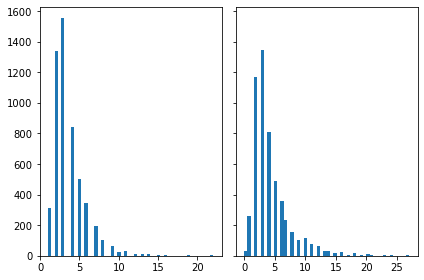

In [22]:
import matplotlib.pyplot as plt
n_bins = 50
len_neg = [len(n) for n in neg_l]
len_hard_neg = [len(n) for n in hard_l]

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(len_neg, bins=n_bins)
axs[1].hist(len_hard_neg, bins=n_bins)

In [39]:
with open('../train_dataset.json', 'r') as f:
    data = json.load(f)

In [19]:
len(data['summary']) # 6396

2132

In [84]:
# translated_triplets = []
# for triplet in triplets_input_data:
# #     temp_translated = [flows[t] for t in triplet]
#     names = {}
#     for x in lanes.values():
#         names.update(x)
#     temp_translated = [names[t] for t in triplet]
#     translated_triplets.append(temp_translated)

# translated_triplets 

In [45]:
translated_triplets = []
for triplet in triplets_input_data:
#     temp_translated = [flows[t] for t in triplet]
    names = {}
    for x in lanes.values():
        names.update(x)
    temp_translated = [names[t] for t in triplet]
    translated_triplets += temp_translated

translated_triplets

['Apply bag tag to bag(s)',
 'Send regular checked in bag(s) to makeup area',
 'Place bag(s) on belf for weighing',
 'Register baggage details',
 'Generate baggage tag ID',
 'Acquire invoice for excess',
 'Advise wether bag(s) backed by self',
 'Deposit regular baggage',
 'Ask passenger if bag(s) packed by self',
 'Apply heavy sticker on bag(s)',
 'Print excess payment invoice',
 'Park bag(s) till payment received',
 'Park bag(s) till payment received',
 'Print excess payment invoice',
 'Apply heavy sticker on bag(s)']